# PROJE AMACI

Halluks valgus, ayak baş parmağının içe doğru kayarak ikinci parmağa doğru yönelmesiyle karakterize edilen bir deformitedir. Bu durum, ayak sağlığını etkileyen yaygın bir sorun olup genellikle ağrı, yorgunluk ve yürüyüş zorluğu gibi belirtilerle kendini gösterir. Bu proje, ayak röntgen görüntüleri üzerinde yapılan görüntü işleme tekniklerini kullanarak halluks valgus'un tespiti için bir otomatik sistem geliştirmeyi amaçlamaktadır. Proje, görüntüdeki baş parmak bölgesindeki deformasyonları belirleyerek, halluks valgus'un varlığını yüksek doğrulukla tanımlamayı hedefler.

# Görüntü Ön İşleme Aşamaları

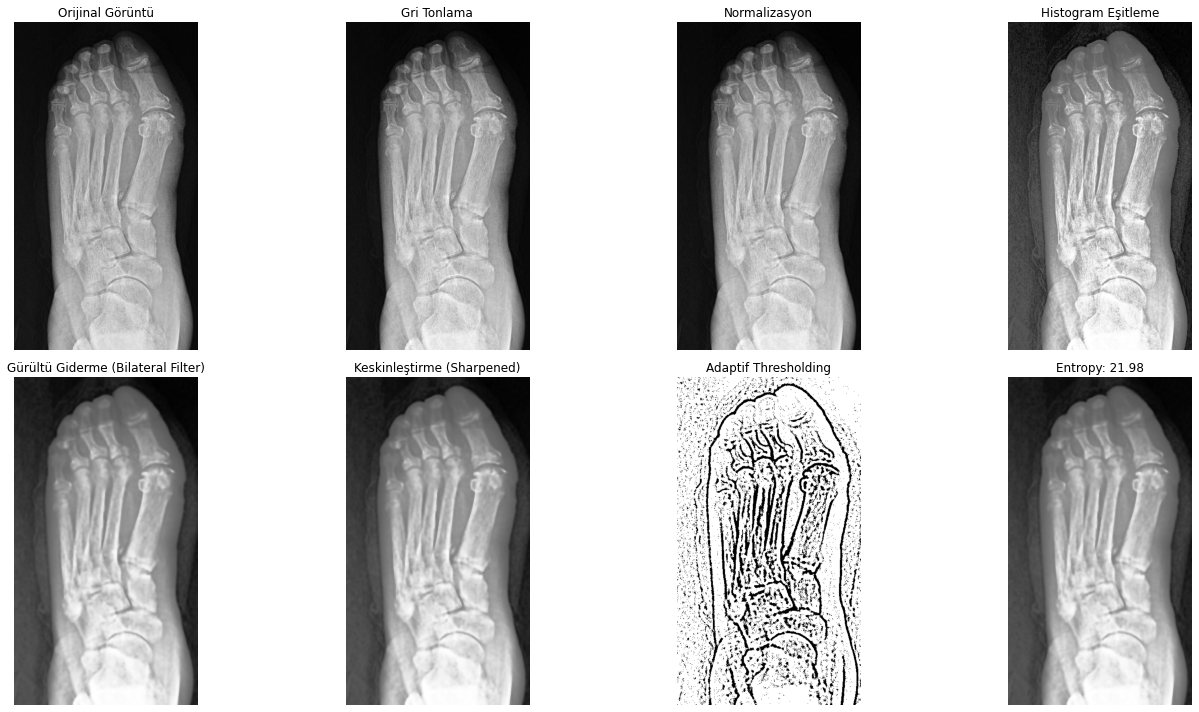

Geliştirilmiş ön işleme adımları tamamlandı.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görüntüyü yükleme
image_path = r"C:\Users\Acer\Desktop\vize\img\img1.png"  # Yeni dosya yolu
image = cv2.imread(image_path)

# Görüntüyü kontrol et
if image is None:
    print("Görüntü yüklenemedi. Lütfen dosya yolunu kontrol edin.")
else:
    # 1. Gri Tonlama
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2. Normalization (Normalizasyon)
    normalized_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX)

    # 3. Histogram Equalization
    equalized_image = cv2.equalizeHist(normalized_image)

    # 4. Bilateral Filter (Noise Reduction)
    bilateral_filtered_image = cv2.bilateralFilter(equalized_image, d=9, sigmaColor=75, sigmaSpace=75)

    # 5. Sharpening (Keskinleştirme)
    blurred_image = cv2.GaussianBlur(bilateral_filtered_image, (5, 5), 0)
    sharpened_image = cv2.addWeighted(bilateral_filtered_image, 1.5, blurred_image, -0.5, 0)

    # 6. Adaptive Thresholding
    adaptive_thresh_image = cv2.adaptiveThreshold(
        sharpened_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # 7. Entropy Filter
    entropy_image = cv2.Laplacian(sharpened_image, cv2.CV_64F).var()

    # Görselleştirme
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 4, 1)
    plt.title("Orijinal Görüntü")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # BGR'den RGB'ye dönüştür
    plt.axis('off')

    plt.subplot(2, 4, 2)
    plt.title("Gri Tonlama")
    plt.imshow(gray_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 4, 3)
    plt.title("Normalizasyon")
    plt.imshow(normalized_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 4, 4)
    plt.title("Histogram Eşitleme")
    plt.imshow(equalized_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 4, 5)
    plt.title("Gürültü Giderme (Bilateral Filter)")
    plt.imshow(bilateral_filtered_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 4, 6)
    plt.title("Keskinleştirme (Sharpened)")
    plt.imshow(sharpened_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 4, 7)
    plt.title("Adaptif Thresholding")
    plt.imshow(adaptive_thresh_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 4, 8)
    plt.title("Entropy: {:.2f}".format(entropy_image))
    plt.imshow(sharpened_image, cmap='gray')  # Entropy görsel değil, bilgi eklenir.
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("Ön işleme adımları tamamlandı.")


# "SIFT Kullanarak Röntgen Görüntülerinde Anahtar Nokta Tespiti"

Bu çalışma, SIFT (Scale-Invariant Feature Transform) algoritması kullanarak halluks valgus tespiti amacıyla röntgen görüntülerindeki belirgin özellikleri tespit etmeyi amaçlamaktadır. İlk olarak, görüntü üzerinde histogram eşitlemesi yapılarak kontrast artırılmış ve ardından maske uygulamasıyla sadece ilgi alanı (big toe) odaklanılmıştır. SIFT algoritması, bu odaklanmış bölgede anahtar noktaları tespit etmek için kullanılmıştır. Bulunan anahtar noktalar, görüntü üzerinde işaretlenerek görselleştirilmiştir. 

Belirlenen bölgede tespit edilen anahtar nokta sayısı: 306


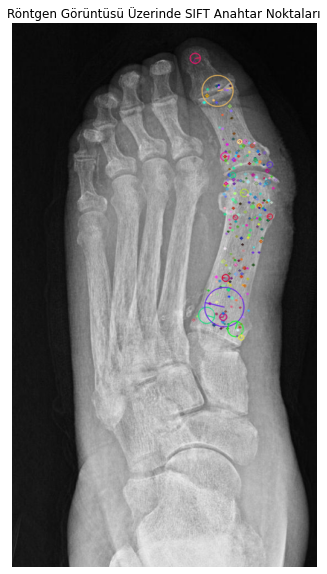

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dosya yolları (raw string kullanarak)
goruntu_dosyasi = r"C:\Users\Acer\Desktop\vize\img\img1.png"  # Gerçek röntgen görüntüsü yolunu buraya yazın
maske_dosyasi = r"C:\Users\Acer\Desktop\vize\label\label1.png" # Gerçek maske görüntüsü yolunu buraya yazın

# Röntgen görüntüsünü ve maskeyi yükleyin
radyografi = cv2.imread(goruntu_dosyasi, cv2.IMREAD_GRAYSCALE)
maske = cv2.imread(maske_dosyasi, cv2.IMREAD_GRAYSCALE)

# Görüntülerin başarıyla yüklendiğinden emin olun
if radyografi is None or maske is None:
    raise ValueError("Görüntü veya maske yüklenemedi. Lütfen dosya yollarını kontrol edin.")

# Histogram eşitleme uygulayın (kontrastı artırmak için)
radyografi_hist = cv2.equalizeHist(radyografi)

# Maskeyi kullanarak röntgen görüntüsünde sadece ilgi alanını çıkarın
ilgi_bolgesi = cv2.bitwise_and(radyografi_hist, radyografi_hist, mask=maske)

# SIFT nesnesini oluştur (daha fazla anahtar nokta için parametreler ayarlandı)
sift_nesnesi = cv2.SIFT_create(contrastThreshold=0.02, edgeThreshold=5, nfeatures=1000)

# İlgi alanında anahtar noktalar ve tanımlayıcılar (descriptors) tespit edin
anahtar_noktalar, tanimlayicilar = sift_nesnesi.detectAndCompute(ilgi_bolgesi, None)

# Anahtar noktaları orijinal görüntüye çizin
anahtar_nokta_goruntusu = cv2.drawKeypoints(
    radyografi, 
    anahtar_noktalar, 
    None, 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# Bulunan anahtar noktaların sayısını yazdırın
print(f"Belirlenen bölgede tespit edilen anahtar nokta sayısı: {len(anahtar_noktalar)}")

# Görüntüyü gösterin (matplotlib kullanarak)
plt.figure(figsize=(10, 10))
plt.imshow(anahtar_nokta_goruntusu, cmap='gray')
plt.title('Röntgen Görüntüsü Üzerinde SIFT Anahtar Noktaları')
plt.axis('off')  # Eksenleri gizleyin
plt.show()




# Anahtar Nokta Tespiti 

 halluks valgus tespiti amacıyla röntgen görüntülerindeki anahtar noktaları tespit etmek için iki önemli görüntü işleme yöntemini bir arada kullanmaktadır: Local Binary Pattern (LBP) ve Scale-Invariant Feature Transform (SIFT). İlk olarak, her bir görüntü için ilgili maske uygulanarak ilgi bölgesi (big toe alanı) belirlenmiştir. Bu ilgi bölgesine LBP uygulanarak dokusal özellikler çıkarılmış ve ardından SIFT kullanılarak bu bölgedeki belirgin anahtar noktalar tespit edilmiştir. Her anahtar noktanın özellikleri (konum, büyüklük, açı, yanıt, oktav) kaydedilmiş ve tüm anahtar noktalar bir dosyada saklanmıştır. Bu yaklaşım, görüntüdeki önemli yapısal özelliklerin belirlenmesinde kullanılacak bir temel sağlar, böylece halluks valgus gibi spesifik hastalıkların tanınmasına yönelik daha ileri düzey analizlerin yapılmasına olanak tanır.

In [15]:
import cv2
import numpy as np
import pickle
import os
from skimage.feature import local_binary_pattern

# LBP ayarları
yaricap = 3
nokta_sayisi = 8 * yaricap
YONTEM = 'uniform'

# Görüntü ve maske yollarının listesi
goruntu_yollari = [r"C:\Users\Acer\Desktop\vize\img\img1.png",
                   r"C:\Users\Acer\Desktop\vize\img\img2.png",
                   r"C:\Users\Acer\Desktop\vize\img\img3.png",
                   r"C:\Users\Acer\Desktop\vize\img\img4.png",
                   r"C:\Users\Acer\Desktop\vize\img\img5.png",
                   r"C:\Users\Acer\Desktop\vize\img\img6.png",
                   r"C:\Users\Acer\Desktop\vize\img\img7.png",
                   r"C:\Users\Acer\Desktop\vize\img\img8.png",
                   r"C:\Users\Acer\Desktop\vize\img\img9.png",
                   r"C:\Users\Acer\Desktop\vize\img\img10.png"]

maske_yollari = [
    r"C:\Users\Acer\Desktop\vize\label\label1.png",
    r"C:\Users\Acer\Desktop\vize\label\label2.png",
    r"C:\Users\Acer\Desktop\vize\label\label3.png",
    r"C:\Users\Acer\Desktop\vize\label\label4.png",
    r"C:\Users\Acer\Desktop\vize\label\label5.png",
    r"C:\Users\Acer\Desktop\vize\label\label6.png",
    r"C:\Users\Acer\Desktop\vize\label\label7.png",
    r"C:\Users\Acer\Desktop\vize\label\label8.png",
    r"C:\Users\Acer\Desktop\vize\label\label9.png",
    r"C:\Users\Acer\Desktop\vize\label\label10.png"
]

# Çıktı dosyası
cikti_dosyasi = r'C:\Users\Acer\Desktop\vize\output_multiple_keypoints.pkl'  # Anahtar noktaların kaydedileceği dosya

# Anahtar noktaları ve tanımlayıcıları saklamak için sözlük
tum_anahtar_noktalar = {}

# Dosyaların varlığını kontrol et
for goruntu_yolu, maske_yolu in zip(goruntu_yollari, maske_yollari):
    if not os.path.exists(goruntu_yolu):
        print(f"Görüntü dosyası bulunamadı: {goruntu_yolu}")
    if not os.path.exists(maske_yolu):
        print(f"Maske dosyası bulunamadı: {maske_yolu}")

# Tüm görüntüler ve maskeler için işlem döngüsü
for goruntu_yolu, maske_yolu in zip(goruntu_yollari, maske_yollari):
    try:
        # Görüntü ve maskeyi yükle
        radyograf = cv2.imread(goruntu_yolu, cv2.IMREAD_GRAYSCALE)
        maske = cv2.imread(maske_yolu, cv2.IMREAD_GRAYSCALE)

        # Görüntülerin başarıyla yüklendiğini kontrol et
        if radyograf is None or maske is None:
            raise ValueError(f"Görüntü veya maske bulunamadı: {goruntu_yolu} veya {maske_yolu}")

        # Boyutları uyumlu hale getir
        if radyograf.shape != maske.shape:
            maske = cv2.resize(maske, (radyograf.shape[1], radyograf.shape[0]))

        # Maskeyi uygulayarak ilgi bölgesini çıkar
        ilgi_bolgesi = cv2.bitwise_and(radyograf, radyograf, mask=maske)

        # İlgi bölgesine LBP uygula
        lbp_sonucu = local_binary_pattern(ilgi_bolgesi, nokta_sayisi, yaricap, YONTEM)

        # LBP sonucunu normalize et
        lbp_normalize = cv2.normalize(lbp_sonucu, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

        # SIFT nesnesi oluştur ve anahtar noktalar ile tanımlayıcıları bul
        sift_nesnesi = cv2.SIFT_create()
        anahtar_noktalar, tanimlayicilar = sift_nesnesi.detectAndCompute(lbp_normalize, None)

        # Anahtar noktaları kaydetmek için liste oluştur
        anahtar_nokta_listesi = []
        if tanimlayicilar is not None:
            for indeks, nokta in enumerate(anahtar_noktalar):
                nokta_verisi = {
                    'pt': nokta.pt,
                    'size': nokta.size,
                    'angle': nokta.angle,
                    'response': nokta.response,
                    'octave': nokta.octave,
                    'class_id': nokta.class_id,
                    'descriptor': tanimlayicilar[indeks]
                }
                anahtar_nokta_listesi.append(nokta_verisi)

        # Anahtar noktaları ana sözlüğe ekle
        goruntu_adi = os.path.basename(goruntu_yolu)  # Görüntü dosya adı
        tum_anahtar_noktalar[goruntu_adi] = anahtar_nokta_listesi

        # Anahtar nokta sayısını ve her anahtar noktanın özelliklerini yazdır
        print(f"{goruntu_adi}: LBP ile tespit edilen anahtar nokta sayısı: {len(anahtar_nokta_listesi)}")
        for i, nokta_verisi in enumerate(anahtar_nokta_listesi):
            print(f"  Anahtar Nokta {i+1}: Konum: {nokta_verisi['pt']}, Büyüklük: {nokta_verisi['size']}, "
                  f"Açı: {nokta_verisi['angle']}, Yanıt: {nokta_verisi['response']}, Oktav: {nokta_verisi['octave']}")

    except Exception as hata:
        print(f"{goruntu_yolu} görüntüsüyle ilgili bir hata oluştu: {hata}")

# Tüm anahtar noktalar bir dosyaya kaydet
# Dosya yolunun doğru olduğundan emin olun
os.makedirs(os.path.dirname(cikti_dosyasi), exist_ok=True)

with open(cikti_dosyasi, 'wb') as f:
    pickle.dump(tum_anahtar_noktalar, f)

print(f"Tüm anahtar noktalar dosyaya kaydedildi: {cikti_dosyasi}")
print("İşlem tamamlandı.")


img1.png: LBP ile tespit edilen anahtar nokta sayısı: 670
  Anahtar Nokta 1: Konum: (236.14695739746094, 33.8310432434082), Büyüklük: 2.1255738735198975, Açı: 149.11195373535156, Yanıt: 0.10617754608392715, Oktav: 12190207
  Anahtar Nokta 2: Konum: (236.14695739746094, 33.8310432434082), Büyüklük: 2.1255738735198975, Açı: 310.8304748535156, Yanıt: 0.10617754608392715, Oktav: 12190207
  Anahtar Nokta 3: Konum: (239.63209533691406, 88.64558410644531), Büyüklük: 13.17827320098877, Açı: 161.43756103515625, Yanıt: 0.013477036729454994, Oktav: 10486529
  Anahtar Nokta 4: Konum: (240.212890625, 55.35511016845703), Büyüklük: 1.971648097038269, Açı: 309.3070068359375, Yanıt: 0.15179914236068726, Oktav: 6750719
  Anahtar Nokta 5: Konum: (240.55203247070312, 47.71409225463867), Büyüklük: 2.0674755573272705, Açı: 328.5414123535156, Yanıt: 0.12296409904956818, Oktav: 10158591
  Anahtar Nokta 6: Konum: (241.1696014404297, 52.51874542236328), Büyüklük: 2.0586495399475098, Açı: 307.9989929199219, Yanı

# Anahtar Noktaların Tespiti ve Eşleştirilmesi

Bu işlem, görüntülerdeki önemli noktaları tespit etmek ve karşılaştırmak amacıyla LBP ve SIFT yöntemlerinin birleştirilmesinin etkilerini incelemek için kullanılır. Halluks valgus gibi tıbbi görüntülerde, bu noktaların doğru şekilde eşleştirilmesi, doğru teşhis ve analiz için önemli olabilir.

Kaydedilen toplam anahtar nokta sayısı: 6705
Yeni görüntüdeki anahtar nokta sayısı (LBP sonrası): 8610
İyi eşleşme sayısı: 522


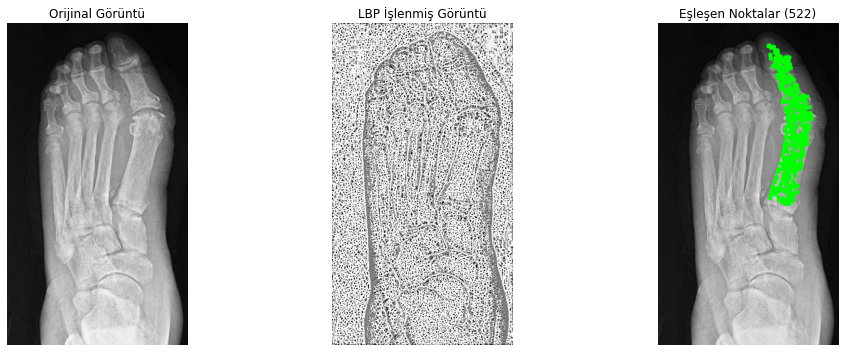

In [23]:
import cv2
import pickle
import numpy as np
import os
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

# LBP ayarları
yaricap = 3
nokta_sayisi = 8 * yaricap
YONTEM = 'uniform'

# Dosya yolları (görüntü ve maske yolları)
goruntu_dosyasi = r"C:\Users\Acer\Desktop\vize\img\img1.png"  # Gerçek röntgen görüntüsü yolunu buraya yazın
maske_dosyasi = r"C:\Users\Acer\Desktop\vize\label\label1.png"  # Güncellenmiş maske yolu

# Kaydedilen anahtar noktalar dosyasının yolu
tum_anahtar_noktalar_dosyasi = r'C:\Users\Acer\Desktop\vize\output_multiple_keypoints.pkl'

# Kaydedilen verileri oku
with open(tum_anahtar_noktalar_dosyasi, 'rb') as dosya:
    tum_anahtar_noktalar = pickle.load(dosya)

# Tüm kaydedilen anahtar noktalar ve tanımlayıcıları birleştir
kaydedilen_noktalar = []
kaydedilen_tanimlayicilar = []

for dosya_adi, nokta_listesi in tum_anahtar_noktalar.items():
    for nokta_verisi in nokta_listesi:
        nokta = cv2.KeyPoint(
            nokta_verisi['pt'][0],
            nokta_verisi['pt'][1],
            nokta_verisi['size'],
            nokta_verisi['angle'],
            nokta_verisi['response'],
            int(nokta_verisi['octave']),
            nokta_verisi['class_id']
        )
        kaydedilen_noktalar.append(nokta)
        kaydedilen_tanimlayicilar.append(nokta_verisi['descriptor'])

# Tanımlayıcıları NumPy dizisine dönüştür
kaydedilen_tanimlayicilar = np.array(kaydedilen_tanimlayicilar, dtype=np.float32)

print(f"Kaydedilen toplam anahtar nokta sayısı: {len(kaydedilen_noktalar)}")

# Yeni görüntüyü yükle
yeni_goruntu = cv2.imread(goruntu_yolu, cv2.IMREAD_GRAYSCALE)
if yeni_goruntu is None:
    raise ValueError(f"{goruntu_yolu} görüntüsü bulunamadı, dosya yolunu kontrol edin.")

# Yeni görüntüye LBP uygula
lbp_yeni = local_binary_pattern(yeni_goruntu, nokta_sayisi, yaricap, YONTEM)

# LBP sonucunu normalize et
lbp_normalize = cv2.normalize(lbp_yeni, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# SIFT nesnesi oluştur
sift_nesnesi = cv2.SIFT_create()

# Yeni LBP görüntüsünden anahtar noktaları ve tanımlayıcıları çıkar
yeni_noktalar, yeni_tanimlayicilar = sift_nesnesi.detectAndCompute(lbp_normalize, None)

print(f"Yeni görüntüdeki anahtar nokta sayısı (LBP sonrası): {len(yeni_noktalar)}")

# Tanımlayıcıların boş olmadığını doğrula
if kaydedilen_tanimlayicilar is None or yeni_tanimlayicilar is None:
    raise ValueError("Tanımlayıcılar boş. Görüntüleri ve anahtar noktaları kontrol edin.")

# FLANN matcher hazırlayın
FLANN_INDEX_KDTREE = 1
indeks_parametreleri = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
arama_parametreleri = dict(checks=50)
flann_esleyici = cv2.FlannBasedMatcher(indeks_parametreleri, arama_parametreleri)

# KNN kullanarak tanımlayıcıları eşleştir
eslesmeler = flann_esleyici.knnMatch(kaydedilen_tanimlayicilar, yeni_tanimlayicilar, k=2)

# Lowe's ratio testi uygulayarak iyi eşleşmeleri al
iyi_eslesmeler = []
for eslesme1, eslesme2 in eslesmeler:
    if eslesme1.distance < 0.65 * eslesme2.distance:
        iyi_eslesmeler.append(eslesme1)

print(f"İyi eşleşme sayısı: {len(iyi_eslesmeler)}")

# Yeni görüntüde eşleşen noktaları çiz
if len(iyi_eslesmeler) > 0:
    yeni_nokta_koordinatlari = [yeni_noktalar[eslesme.trainIdx].pt for eslesme in iyi_eslesmeler]
    eslesen_goruntu = cv2.cvtColor(yeni_goruntu, cv2.COLOR_GRAY2BGR)
    for koordinat in yeni_nokta_koordinatlari:
        cv2.circle(eslesen_goruntu, (int(koordinat[0]), int(koordinat[1])), 5, (0, 255, 0), -1)

# Görselleri yan yana göster
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Orijinal görüntü
axs[0].imshow(yeni_goruntu, cmap='gray')
axs[0].set_title("Orijinal Görüntü")
axs[0].axis('off')

# LBP ile işlenmiş görüntü
axs[1].imshow(lbp_normalize, cmap='gray')
axs[1].set_title("LBP İşlenmiş Görüntü")
axs[1].axis('off')

# Eşleşen anahtar noktalar
if len(iyi_eslesmeler) > 0:
    axs[2].imshow(cv2.cvtColor(eslesen_goruntu, cv2.COLOR_BGR2RGB))
    axs[2].set_title(f"Eşleşen Noktalar ({len(iyi_eslesmeler)})")
else:
    axs[2].imshow(yeni_goruntu, cmap='gray')
    axs[2].set_title("Eşleşme Bulunamadı")
axs[2].axis('off')

plt.tight_layout()
plt.show()




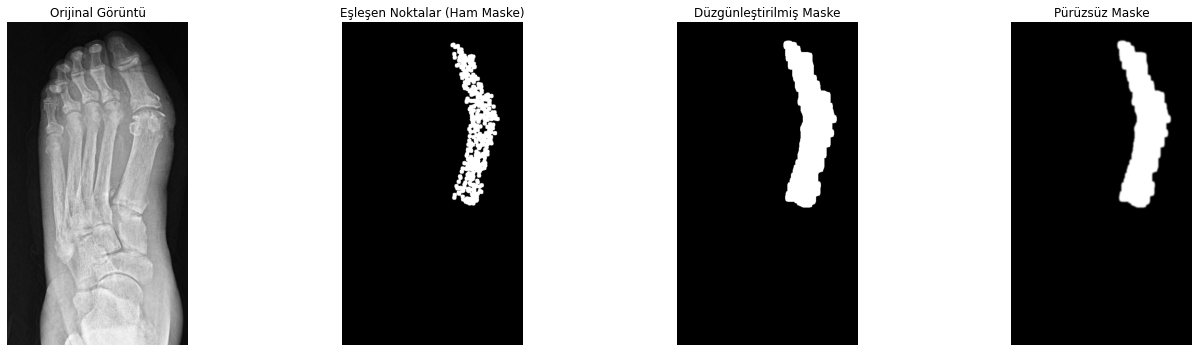

Düzgünleştirilmiş maske kaydedildi: C:/Users/user/Desktop/vize/smooth_output_mask.png


In [17]:
import cv2
import pickle
import numpy as np
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

# LBP ayarları
yaricap = 3
nokta_sayisi = 8 * yaricap
YONTEM = 'uniform'

# Dosya yolları
goruntu_yolu = r"C:\Users\Acer\Desktop\vize\img\img1.png"
tum_anahtar_noktalar_dosyasi = r'C:\Users\Acer\Desktop\vize\output_multiple_keypoints.pkl'

# Kaydedilen anahtar noktaları oku
with open(tum_anahtar_noktalar_dosyasi, 'rb') as dosya:
    tum_anahtar_noktalar = pickle.load(dosya)

kaydedilen_tanimlayicilar = []
for _, nokta_listesi in tum_anahtar_noktalar.items():
    for nokta_verisi in nokta_listesi:
        kaydedilen_tanimlayicilar.append(nokta_verisi['descriptor'])

kaydedilen_tanimlayicilar = np.array(kaydedilen_tanimlayicilar, dtype=np.float32)

# Yeni görüntüyü yükle
yeni_goruntu = cv2.imread(goruntu_yolu, cv2.IMREAD_GRAYSCALE)
if yeni_goruntu is None:
    raise ValueError(f"{goruntu_yolu} görüntüsü bulunamadı, dosya yolunu kontrol edin.")

# Yeni görüntüye LBP uygula
lbp_yeni = local_binary_pattern(yeni_goruntu, nokta_sayisi, yaricap, YONTEM)
lbp_normalize = cv2.normalize(lbp_yeni, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# SIFT nesnesi oluştur
sift_nesnesi = cv2.SIFT_create()
yeni_noktalar, yeni_tanimlayicilar = sift_nesnesi.detectAndCompute(lbp_normalize, None)

# FLANN matcher
FLANN_INDEX_KDTREE = 1
indeks_parametreleri = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
arama_parametreleri = dict(checks=50)
flann_esleyici = cv2.FlannBasedMatcher(indeks_parametreleri, arama_parametreleri)

eslesmeler = flann_esleyici.knnMatch(kaydedilen_tanimlayicilar, yeni_tanimlayicilar, k=2)
iyi_eslesmeler = [m1 for m1, m2 in eslesmeler if m1.distance < 0.65 * m2.distance]

# Eşleşen noktaları maske üzerinde işaretle
maske = np.zeros_like(yeni_goruntu, dtype=np.uint8)
for eslesme in iyi_eslesmeler:
    koordinat = yeni_noktalar[eslesme.trainIdx].pt
    cv2.circle(maske, (int(koordinat[0]), int(koordinat[1])), radius=5, color=255, thickness=-1)

# Kenarları düzgünleştirme ve içini doldurma
cekirdek = np.ones((5, 5), np.uint8)
maske_dilated = cv2.dilate(maske, cekirdek, iterations=5)
maske_eroded = cv2.erode(maske_dilated, cekirdek, iterations=3)
maske_blurred = cv2.GaussianBlur(maske_eroded, (7, 7), 0)

# Görselleri göster
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(yeni_goruntu, cmap='gray')
axs[0].set_title("Orijinal Görüntü")
axs[0].axis('off')

axs[1].imshow(maske, cmap='gray')
axs[1].set_title("Eşleşen Noktalar (Ham Maske)")
axs[1].axis('off')

axs[2].imshow(maske_eroded, cmap='gray')
axs[2].set_title("Düzgünleştirilmiş Maske")
axs[2].axis('off')

axs[3].imshow(maske_blurred, cmap='gray')
axs[3].set_title("Pürüzsüz Maske")
axs[3].axis('off')

plt.tight_layout()
plt.show()

# Maske olarak kaydet
cikti_maske_yolu = r"C:/Users/user/Desktop/vize/smooth_output_mask.png"
cv2.imwrite(cikti_maske_yolu, maske_blurred)
print(f"Düzgünleştirilmiş maske kaydedildi: {cikti_maske_yolu}")

Çıkarılan maske ile orijinal maske arasındaki IoU benzerlik oranı: 0.9096


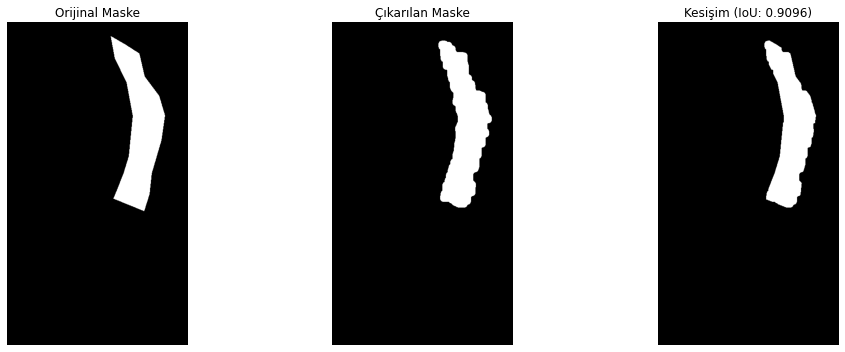

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Çıkarılan maskenin görüntüsü (maske_blurred daha önce oluşturulmuştu)
# Eğer maske_blurred yoksa onun yerine çıkarılan maskeyi burada tanımlayın
son_maske = maske_blurred

# Orijinal maskeyi yükle
maske_yolu = r"C:\Users\Acer\Desktop\vize\label\label1.png" 
orijinal_maske = cv2.imread(maske_yolu, cv2.IMREAD_GRAYSCALE)

if orijinal_maske is None:
    raise ValueError(f"{maske_yolu} maskesi yüklenemedi!")

# İkili hale getir (binary thresholding)
_, son_maske_bin = cv2.threshold(son_maske, 127, 255, cv2.THRESH_BINARY)
_, orijinal_maske_bin = cv2.threshold(orijinal_maske, 127, 255, cv2.THRESH_BINARY)

# Boyutları eşleştir
if son_maske_bin.shape != orijinal_maske_bin.shape:
    orijinal_maske_bin = cv2.resize(orijinal_maske_bin, (son_maske_bin.shape[1], son_maske_bin.shape[0]))

# IoU hesaplama
kesisim = np.logical_and(orijinal_maske_bin, son_maske_bin)
birlesim = np.logical_or(orijinal_maske_bin, son_maske_bin)
iou_puani = np.sum(kesisim) / np.sum(birlesim)

# Sonucu yazdır
print(f"Çıkarılan maske ile orijinal maske arasındaki IoU benzerlik oranı: {iou_puani:.4f}")

# Görselleri göster
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Orijinal Maske")
plt.imshow(orijinal_maske_bin, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Çıkarılan Maske")
plt.imshow(son_maske_bin, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Kesişim (IoU: {iou_puani:.4f})")
plt.imshow(kesisim, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

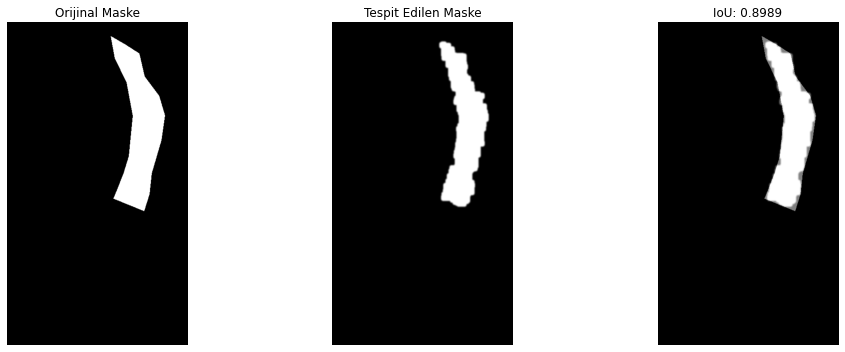

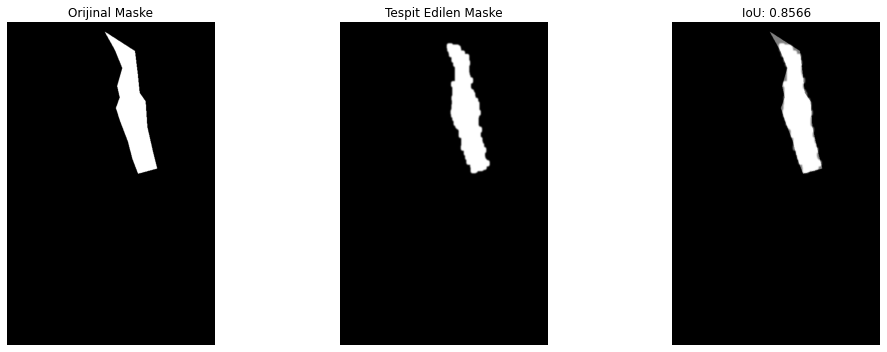

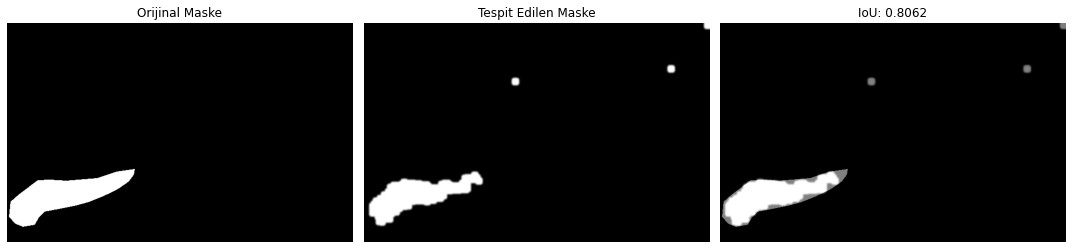

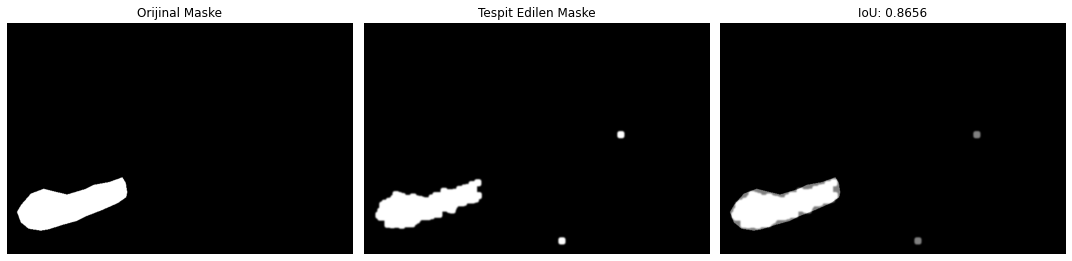

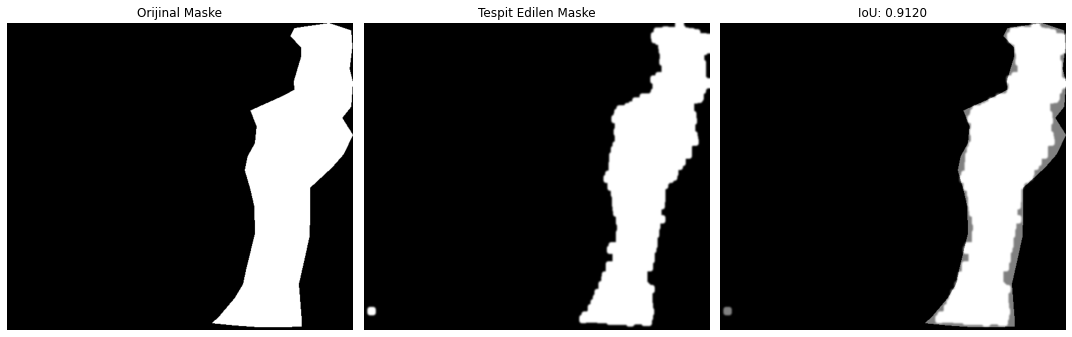

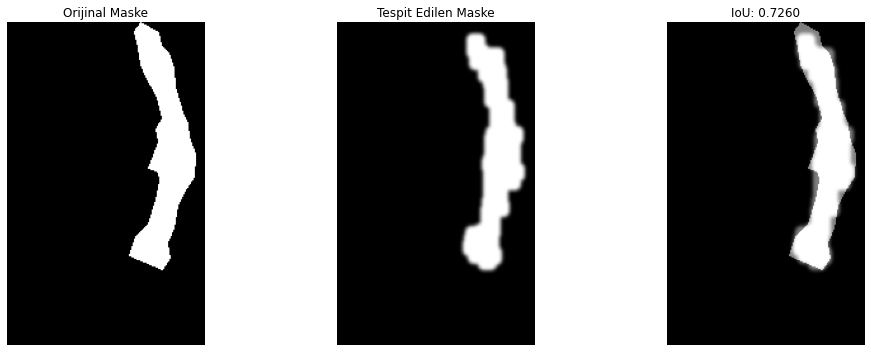

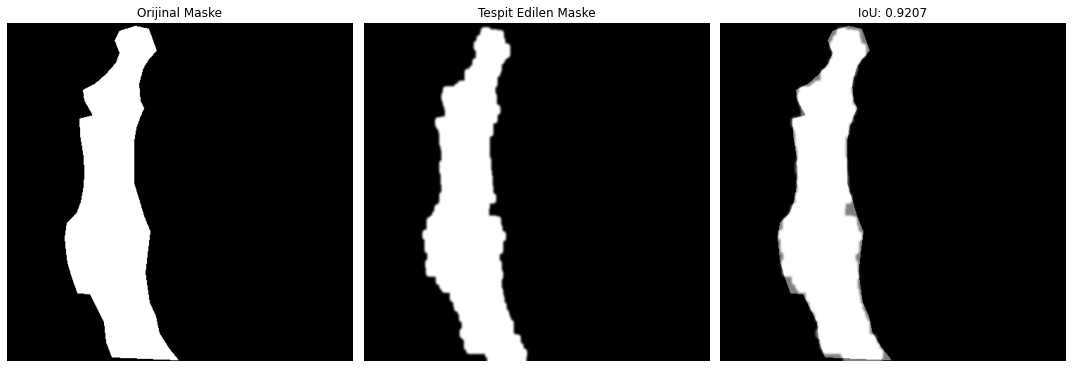

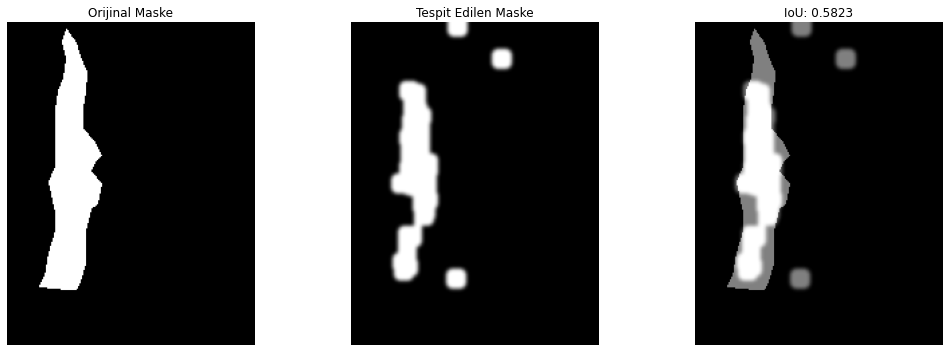

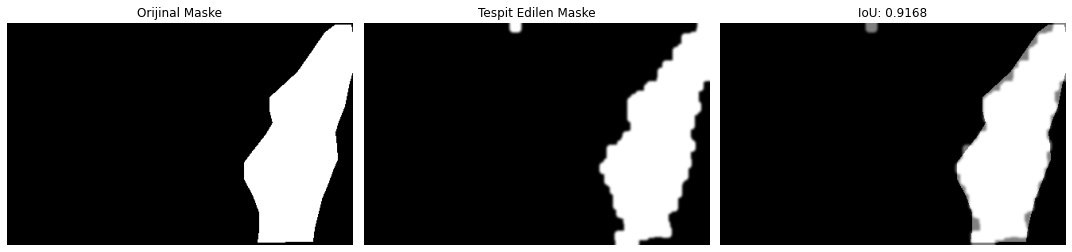

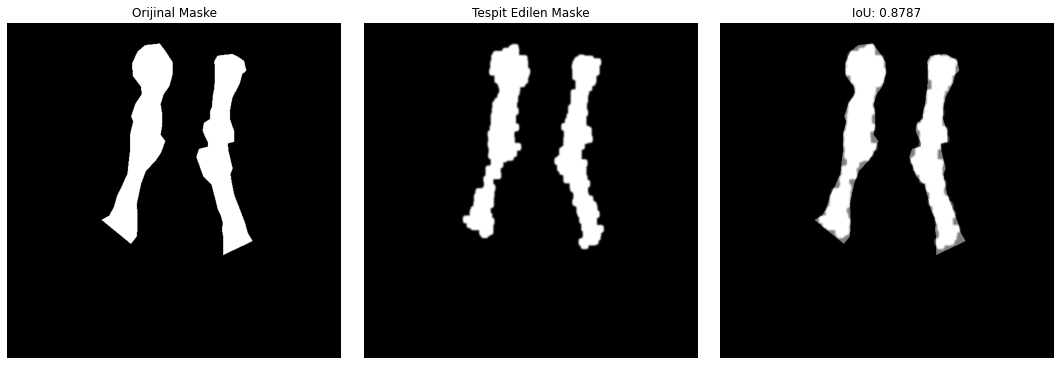

Ortalama IoU Skoru: 0.8364


In [20]:
import cv2
import numpy as np
import pickle
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

# LBP ayarları
yaricap = 3
nokta_sayisi = 8 * yaricap
YONTEM = 'uniform'

# Dosya yolları (10 görüntü ve maskelerinin yolları)
goruntu_yollari = [
      r"C:\Users\Acer\Desktop\vize\img\img1.png" ,
    r"C:\Users\Acer\Desktop\vize\img\img2.png" ,
    r"C:\Users\Acer\Desktop\vize\img\img3.png" ,
    r"C:\Users\Acer\Desktop\vize\img\img4.png" ,
    r"C:\Users\Acer\Desktop\vize\img\img5.png" ,
    r"C:\Users\Acer\Desktop\vize\img\img6.png" ,
    r"C:\Users\Acer\Desktop\vize\img\img7.png" ,
    r"C:\Users\Acer\Desktop\vize\img\img8.png" ,
    r"C:\Users\Acer\Desktop\vize\img\img9.png" ,
    r"C:\Users\Acer\Desktop\vize\img\img10.png"
]

maske_yollari = [
     r"C:\Users\Acer\Desktop\vize\label\label1.png", 
     r"C:\Users\Acer\Desktop\vize\label\label2.png",
     r"C:\Users\Acer\Desktop\vize\label\label3.png",
     r"C:\Users\Acer\Desktop\vize\label\label4.png",
     r"C:\Users\Acer\Desktop\vize\label\label5.png",
     r"C:\Users\Acer\Desktop\vize\label\label6.png",
     r"C:\Users\Acer\Desktop\vize\label\label7.png",
     r"C:\Users\Acer\Desktop\vize\label\label8.png",
     r"C:\Users\Acer\Desktop\vize\label\label9.png",
     r"C:\Users\Acer\Desktop\vize\label\label10.png"
]
    

# Anahtar noktalarının kaydedildiği dosya
anahtar_noktalar_dosyasi =r'C:/Users/Acer/Desktop/vize/output_multiple_keypoints.pkl'

# Kaydedilen verileri oku
with open(anahtar_noktalar_dosyasi, 'rb') as dosya:
    tum_anahtar_noktalar = pickle.load(dosya)

# Tüm kaydedilen anahtar noktaları ve tanımlayıcıları birleştir
kaydedilen_tanimlayicilar = []
for _, nokta_listesi in tum_anahtar_noktalar.items():
    for nokta_verisi in nokta_listesi:
        kaydedilen_tanimlayicilar.append(nokta_verisi['descriptor'])
kaydedilen_tanimlayicilar = np.array(kaydedilen_tanimlayicilar, dtype=np.float32)

# IoU değerlerini saklamak için liste
iou_skorlari = []

# Her bir görüntü ve maske çifti için işlemleri uygula
for yeni_goruntu_yolu, orijinal_maske_yolu in zip(goruntu_yollari, maske_yollari):
    yeni_goruntu = cv2.imread(yeni_goruntu_yolu, cv2.IMREAD_GRAYSCALE)
    orijinal_maske = cv2.imread(orijinal_maske_yolu, cv2.IMREAD_GRAYSCALE)

    if yeni_goruntu is None or orijinal_maske is None:
        print(f"Görüntü veya maske yüklenemedi: {yeni_goruntu_yolu}, {orijinal_maske_yolu}")
        continue

    # Yeni görüntüye LBP uygula
    lbp_yeni = local_binary_pattern(yeni_goruntu, nokta_sayisi, yaricap, YONTEM)
    lbp_normalize = cv2.normalize(lbp_yeni, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # SIFT nesnesini oluştur
    sift_nesnesi = cv2.SIFT_create()

    # Anahtar noktaları ve tanımlayıcıları çıkar
    yeni_noktalar, yeni_tanimlayicilar = sift_nesnesi.detectAndCompute(lbp_normalize, None)
    if yeni_tanimlayicilar is None:
        print(f"Tanımlayıcılar bulunamadı: {yeni_goruntu_yolu}")
        continue

    # FLANN matcher ile eşleştirme
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    eslesmeler = flann.knnMatch(kaydedilen_tanimlayicilar, yeni_tanimlayicilar, k=2)
    iyi_eslesmeler = [m1 for m1, m2 in eslesmeler if m1.distance < 0.65 * m2.distance]

    # Eşleşen noktaları maske üzerine işaretle
    eslesme_maske = np.zeros_like(yeni_goruntu, dtype=np.uint8)
    for eslesme in iyi_eslesmeler:
        koordinat = tuple(map(int, yeni_noktalar[eslesme.trainIdx].pt))
        cv2.circle(eslesme_maske, koordinat, radius=3, color=255, thickness=-1)

    # Pürüzsüzleştirme ve maske iyileştirme
    kernel = np.ones((5, 5), np.uint8)
    duzenlenmis_maske = cv2.dilate(eslesme_maske, kernel, iterations=4)
    duzenlenmis_maske = cv2.erode(duzenlenmis_maske, kernel, iterations=2)
    son_maske = cv2.GaussianBlur(duzenlenmis_maske, (7, 7), 0)

    # IoU hesaplama
    kesisim = np.logical_and(orijinal_maske > 0, son_maske > 0)
    birlesim = np.logical_or(orijinal_maske > 0, son_maske > 0)
    iou_puani = np.sum(kesisim) / np.sum(birlesim)
    iou_skorlari.append(iou_puani)

    # Sonuçları görselleştir
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Orijinal Maske")
    plt.imshow(orijinal_maske, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Tespit Edilen Maske")
    plt.imshow(son_maske, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"IoU: {iou_puani:.4f}")
    ust_uste = cv2.addWeighted(orijinal_maske.astype(np.uint8), 0.5, son_maske.astype(np.uint8), 0.5, 0)
    plt.imshow(ust_uste, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Ortalama IoU
ortalama_iou = np.mean(iou_skorlari)
print(f"Ortalama IoU Skoru: {ortalama_iou:.4f}")


In [ ]:
skel komutu  adımalrı ekle hepsını 